  <tr>
        <td>
            <div align="left">
                <font size=25px>
                    <b>S&P Anomaly Detection
                    </b>
                </font>
            </div>
        </td>
    </tr>

## Problem Statement

The S&P 500, or just the S&P, is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the U.S. stock market.

We are going to detect anomalies in the time series of S&P data using LSTM (Long Time Short Memory) auto-encoders.

## Data

Compiled dataset containing Daily Closing Prices for the S&P going from 1986 to 2018.

## Content
1. **[Import Libraries](#import_packages)**
2. **[Read the Data](#read_data)**
3. **[Preparing and Pre-processing the Data](#data_preprocess)**
    - 3.1 - [Splitting the data into 95% train and 5% test set](#splitting)
    - 3.2 - [Scaling the Data](#scaling)
    - 3.3 - [Splitting the Data into subsequences](#split_subsequences)
4. **[Model Building](#modeling)**
5. **[Finding Anomalies](#find_anomaly)**
    - 5.1 - [Model 1](#model1)
    - 5.2 - [Model 2](#model2)
    - 5.3 - [Model 3](#model3)

<a name='import_packages'></a>
## 1. Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, Dropout, TimeDistributed, Dense
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings("ignore")
%pylab inline

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Populating the interactive namespace from numpy and matplotlib


Check devices

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2422051526592643581
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8380149907692244753
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

<a name='read_data'></a>
## 2. Read the Data

In [3]:
sp_df = pd.read_csv("/content/spx.csv", parse_dates=["date"], index_col="date")
sp_df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


Plotting the time series data

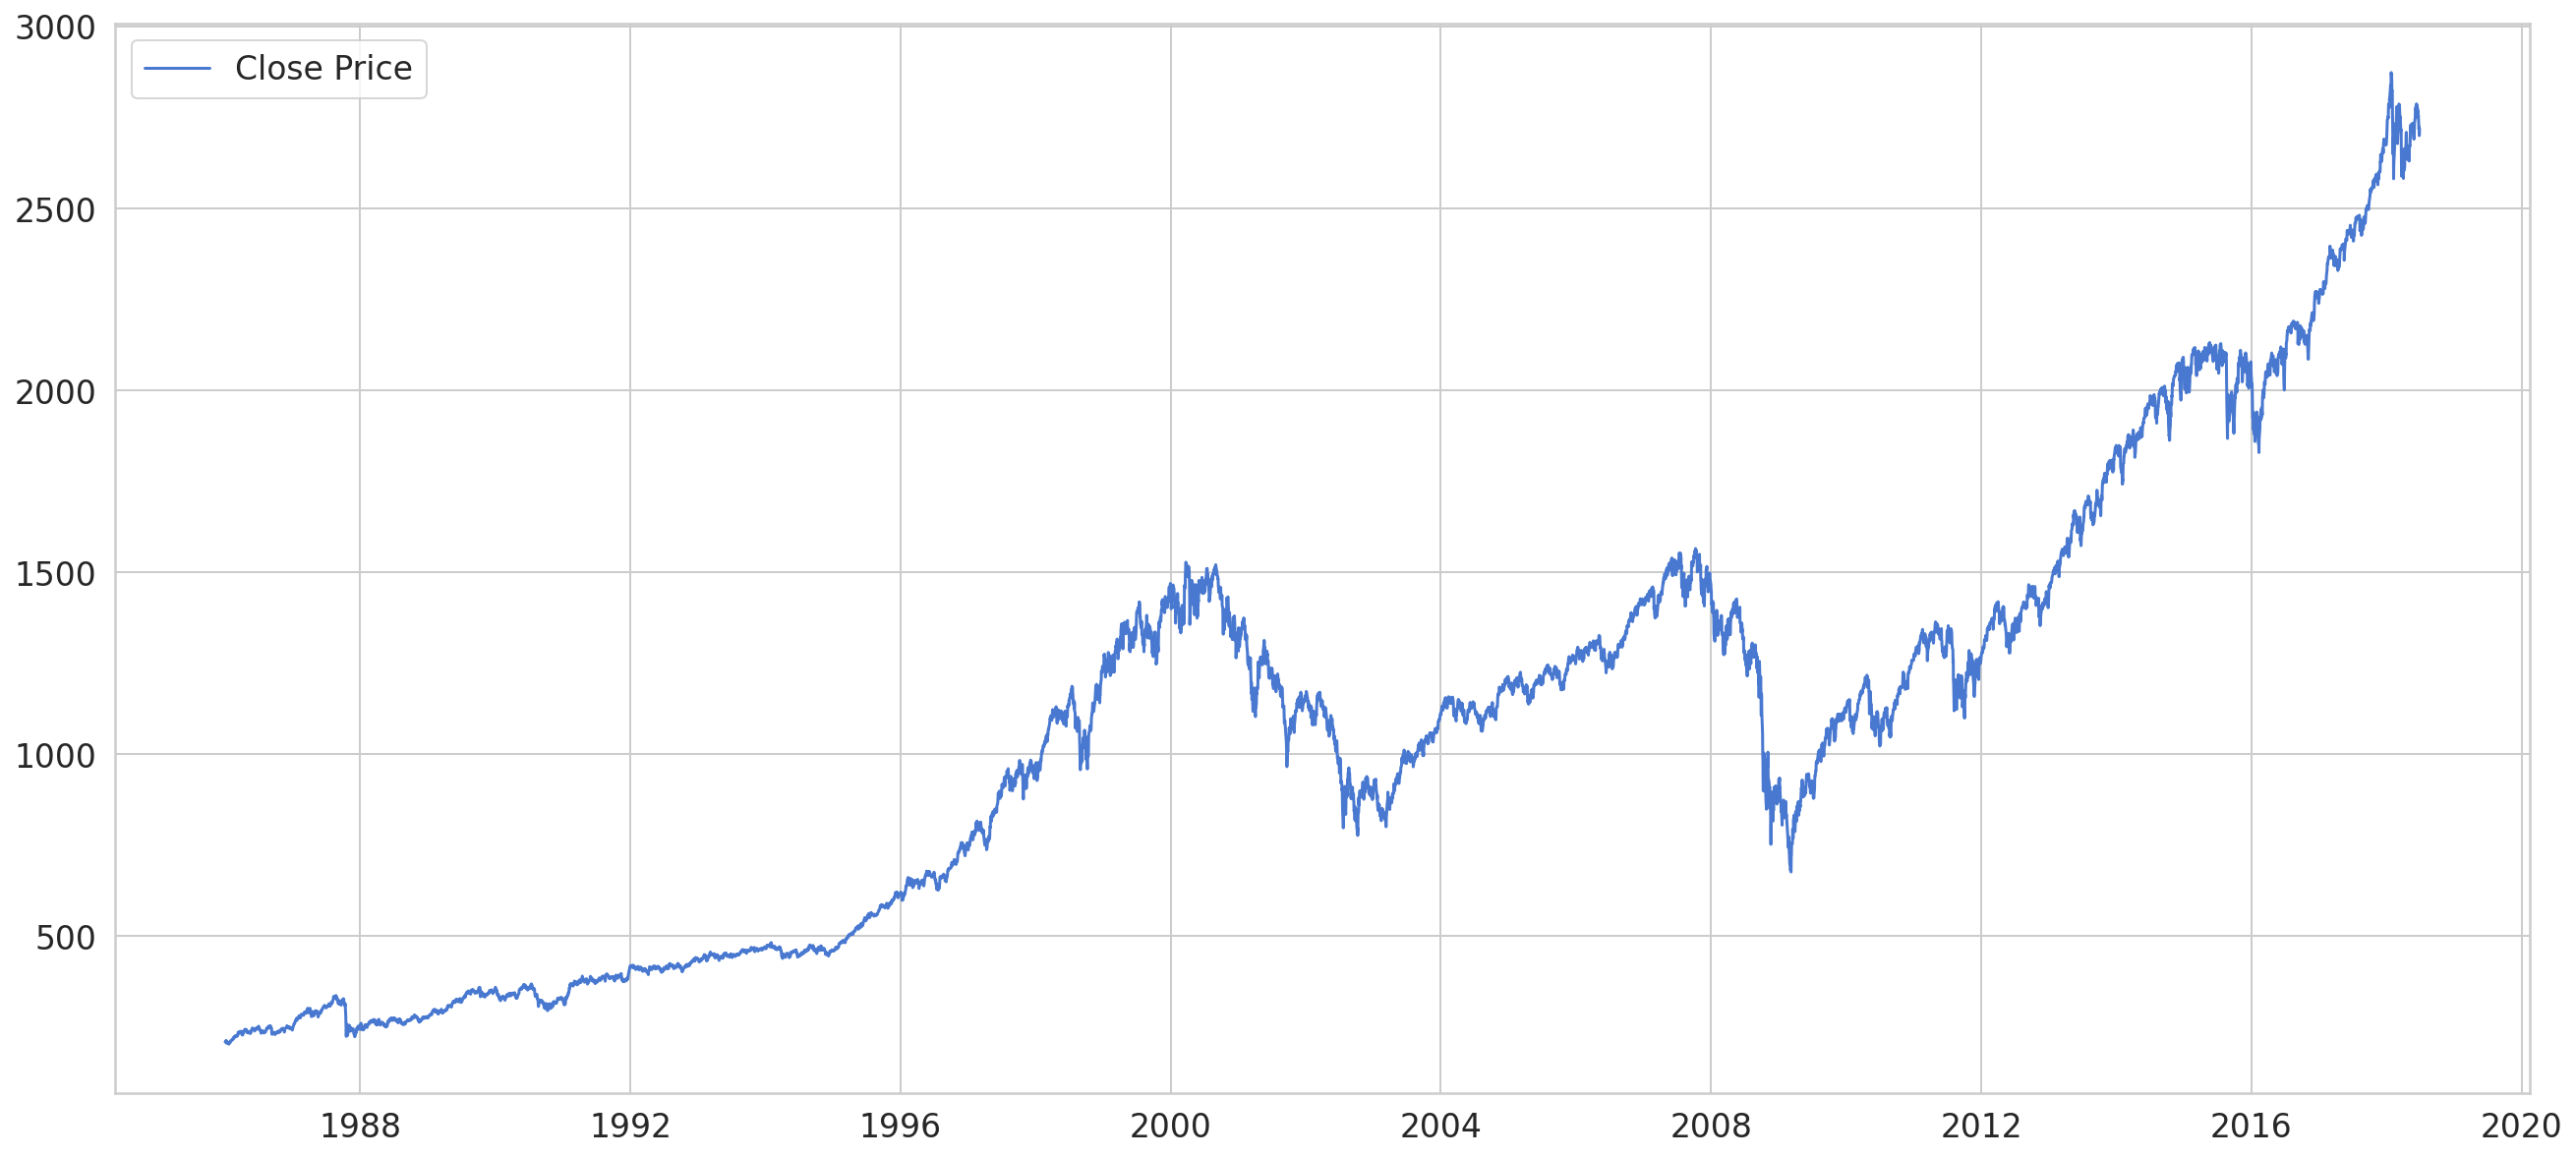

In [4]:
plt.plot(sp_df, label='Close Price')
plt.legend()
plt.show()

<a name='data_preprocess'></a>
## 3. Preparing & Pre-processing the Data

<a name='splitting'></a>
### 3.1. Splitting the data into 95% train and 5% test set

In [5]:
train_size = int(len(sp_df) * 0.95)
test_size = len(sp_df) - train_size
train, test = sp_df.iloc[0:train_size], sp_df.iloc[train_size:len(sp_df)]

print("Training size: ", train.shape)
print("Testing size: ", test.shape)

Training size:  (7782, 1)
Testing size:  (410, 1)


<a name='scaling'></a>
### 3.2. Scaling the Data

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[["close"]])

train["close"] = scaler.transform(train[["close"]])
test["close"] = scaler.transform(test[["close"]])

<a name='split_subsequences'></a>
### 3.3. Splitting the Data into subsequences

In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Creating sequences with 30 days worth of historical data

In [8]:
TIME_STEPS = 30

# Reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


<a name='modeling'></a>
## 4. Model Building

**LSTM (Long Short Term Memory)**

In [9]:
model1 = Sequential()

model1.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]) ))
model1.add(Dropout(0.2))
model1.add(RepeatVector(n=X_train.shape[1]))

model1.add(LSTM(64, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(TimeDistributed(Dense(X_train.shape[2])))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                                

In [10]:
model1.compile(loss='mae', optimizer='adam')

In [11]:
hist1 = model1.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 11s 18ms/step - loss: 0.1736 - val_loss: 0.2234
Epoch 2/10
218/218 [==============================] - 2s 10ms/step - loss: 0.1018 - val_loss: 0.1828
Epoch 3/10
218/218 [==============================] - 2s 10ms/step - loss: 0.1004 - val_loss: 0.1607
Epoch 4/10
218/218 [==============================] - 2s 10ms/step - loss: 0.1181 - val_loss: 0.2427
Epoch 5/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1260 - val_loss: 0.3079
Epoch 6/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1203 - val_loss: 0.3112
Epoch 7/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1147 - val_loss: 0.1527
Epoch 8/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1057 - val_loss: 0.1750
Epoch 9/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1274 - val_loss: 0.1366
Epoch 10/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1250 - val_loss: 0

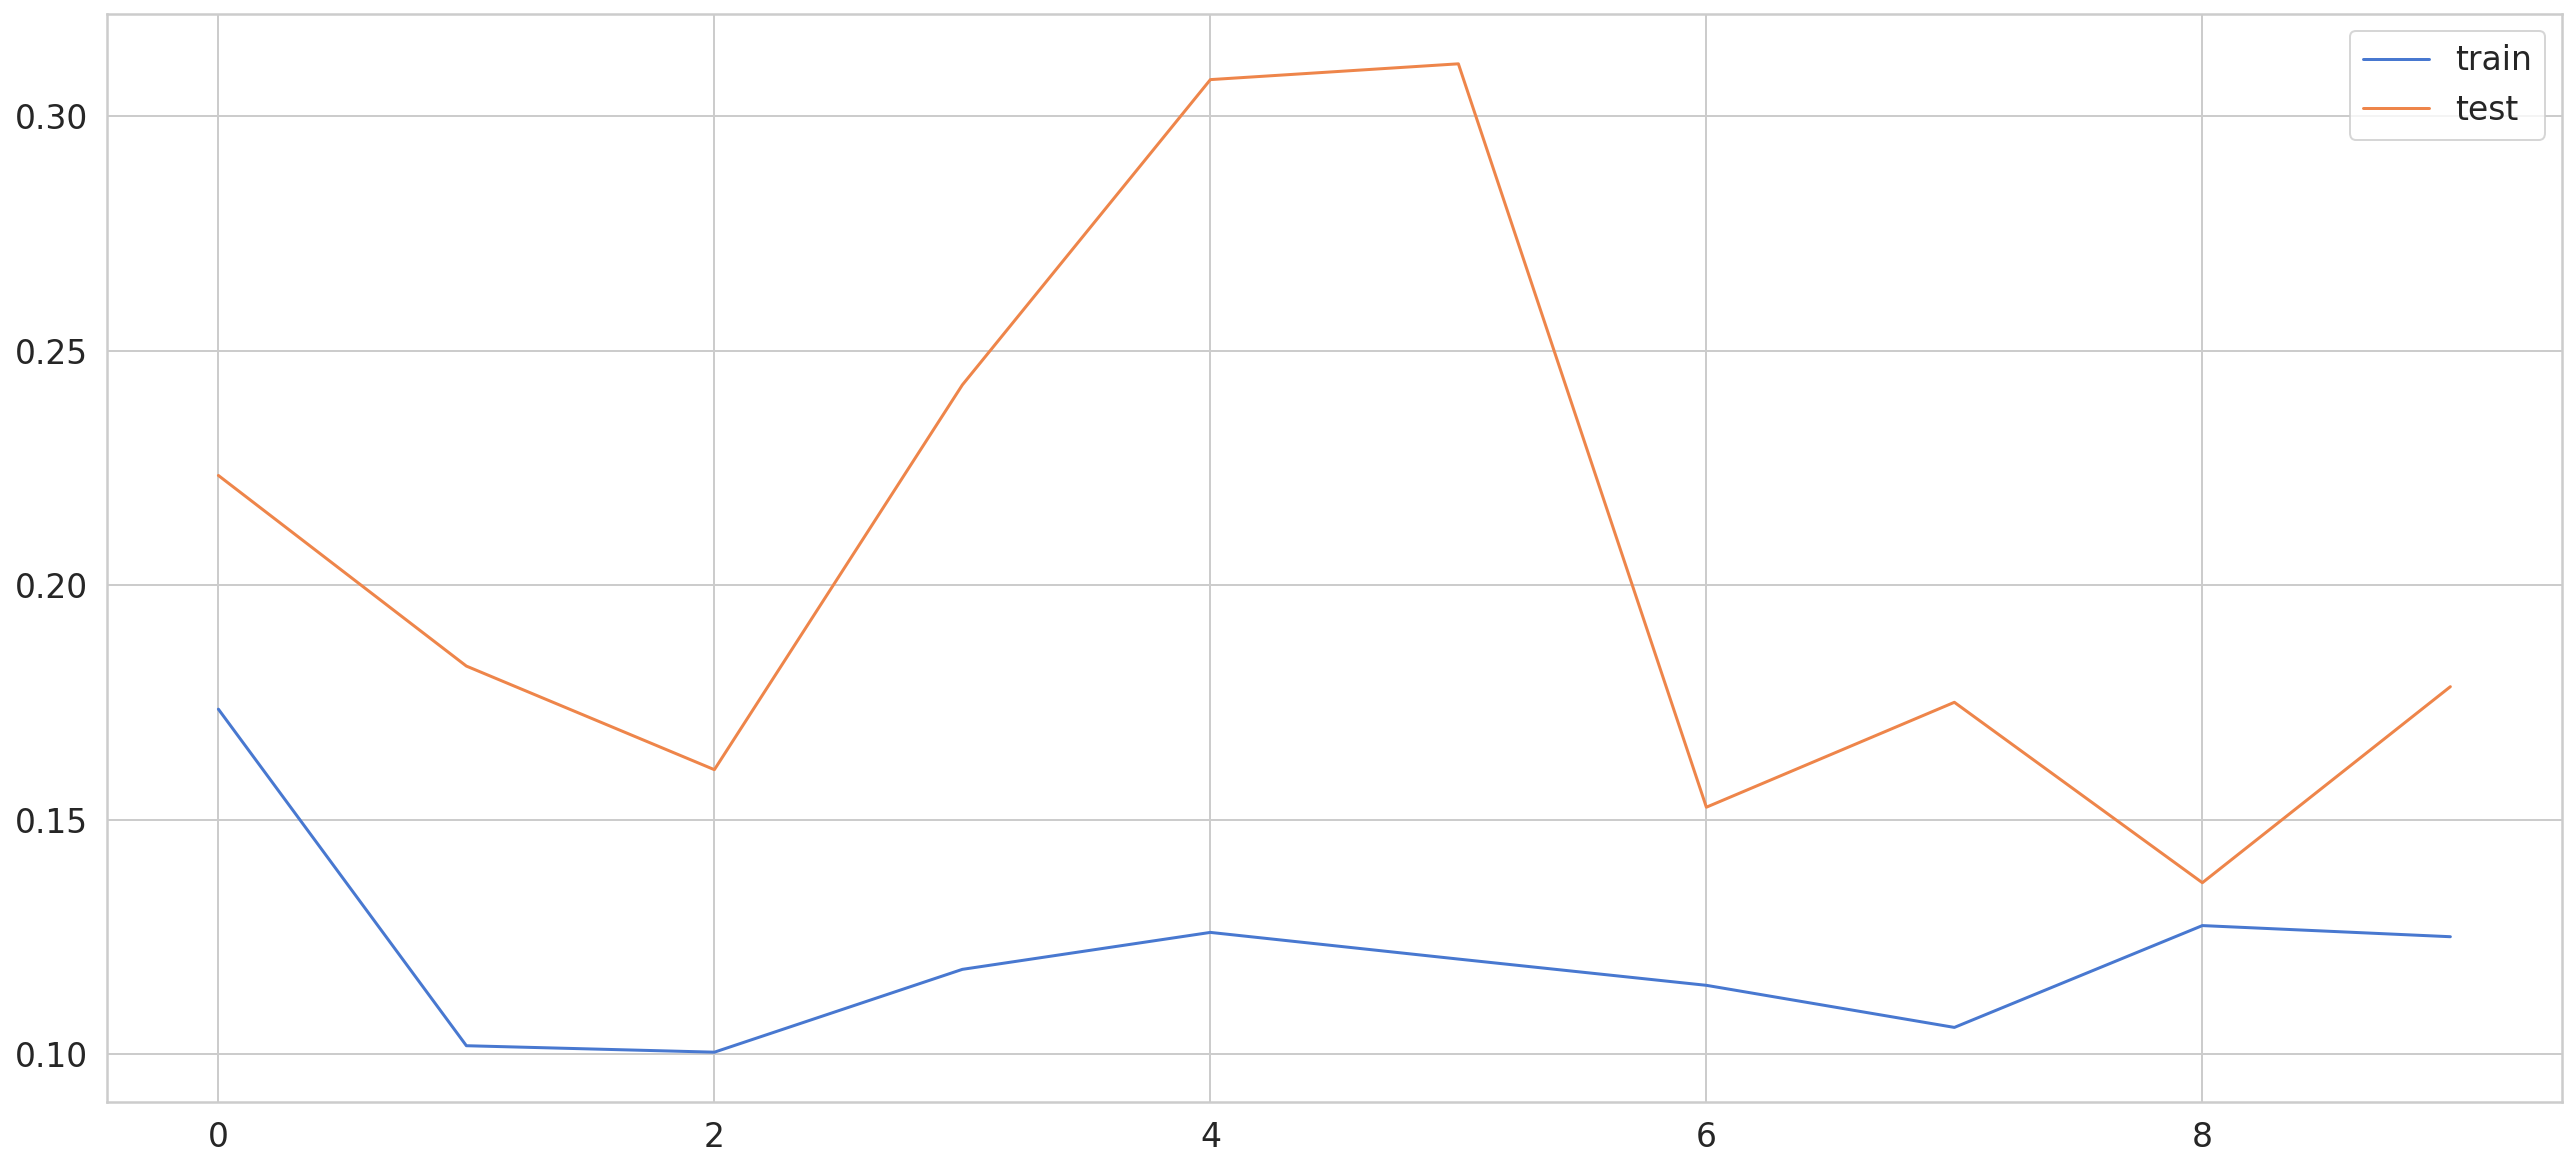

In [12]:
plt.plot(hist1.history['loss'], label='train')
plt.plot(hist1.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
model2 = Sequential()

model2.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]) ))
model2.add(Dropout(0.3))
model2.add(RepeatVector(n=X_train.shape[1]))

model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(TimeDistributed(Dense(X_train.shape[2])))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

In [14]:
model2.compile(loss='mae', optimizer='adam')

In [15]:
hist2 = model2.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 5s 11ms/step - loss: 0.1566 - val_loss: 0.2769
Epoch 2/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1025 - val_loss: 0.2027
Epoch 3/10
218/218 [==============================] - 2s 7ms/step - loss: 0.0914 - val_loss: 0.2006
Epoch 4/10
218/218 [==============================] - 2s 8ms/step - loss: 0.0939 - val_loss: 0.2183
Epoch 5/10
218/218 [==============================] - 2s 7ms/step - loss: 0.1017 - val_loss: 0.1846
Epoch 6/10
218/218 [==============================] - 2s 8ms/step - loss: 0.1028 - val_loss: 0.1733
Epoch 7/10
218/218 [==============================] - 2s 7ms/step - loss: 0.1034 - val_loss: 0.0972
Epoch 8/10
218/218 [==============================] - 2s 7ms/step - loss: 0.1017 - val_loss: 0.1176
Epoch 9/10
218/218 [==============================] - 2s 7ms/step - loss: 0.1033 - val_loss: 0.1162
Epoch 10/10
218/218 [==============================] - 2s 7ms/step - loss: 0.1043 - val_loss: 0.110

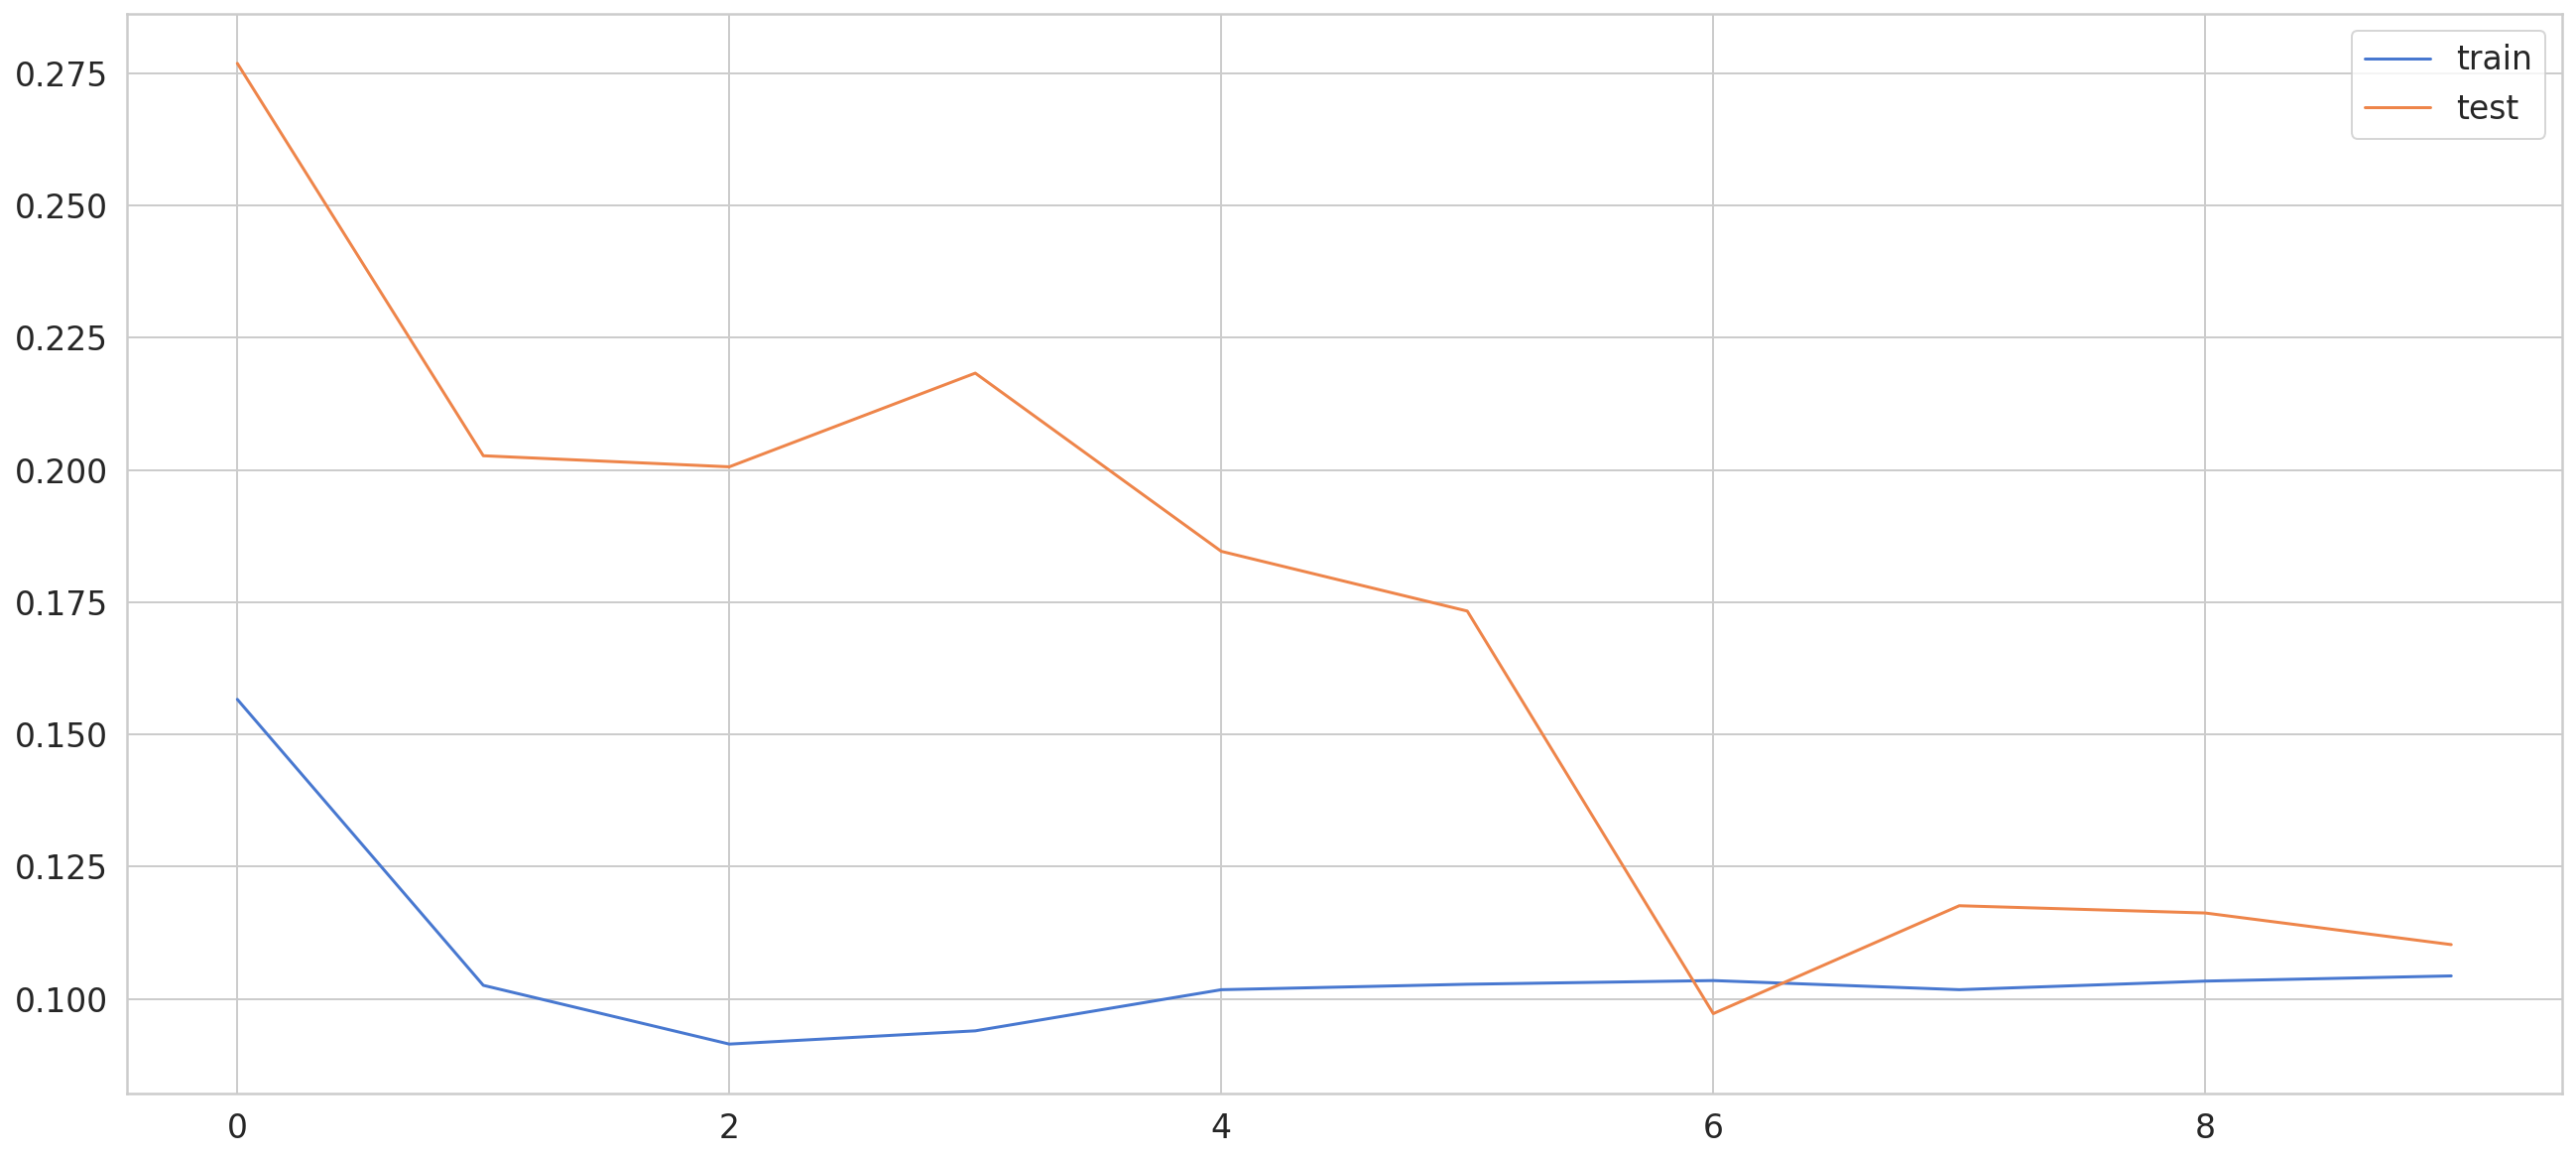

In [16]:
plt.plot(hist2.history['loss'], label='train')
plt.plot(hist2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [17]:
model3 = Sequential()

model3.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]) ))
model3.add(Dropout(0.5))
model3.add(RepeatVector(n=X_train.shape[1]))

model3.add(LSTM(128, return_sequences=True))
model3.add(Dropout(0.5))
model3.add(TimeDistributed(Dense(X_train.shape[2])))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 64)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           98816     
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

In [18]:
model3.compile(loss='mae', optimizer='adam')

In [19]:
hist3 = model3.fit(
    X_train, y_train,
    epochs=9,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/9
218/218 [==============================] - 5s 10ms/step - loss: 0.2016 - val_loss: 0.1958
Epoch 2/9
218/218 [==============================] - 2s 7ms/step - loss: 0.1322 - val_loss: 0.3212
Epoch 3/9
218/218 [==============================] - 1s 7ms/step - loss: 0.1303 - val_loss: 0.1828
Epoch 4/9
218/218 [==============================] - 2s 7ms/step - loss: 0.1238 - val_loss: 0.2058
Epoch 5/9
218/218 [==============================] - 2s 7ms/step - loss: 0.1217 - val_loss: 0.1429
Epoch 6/9
218/218 [==============================] - 2s 7ms/step - loss: 0.1257 - val_loss: 0.1896
Epoch 7/9
218/218 [==============================] - 2s 7ms/step - loss: 0.1352 - val_loss: 0.1599
Epoch 8/9
218/218 [==============================] - 2s 7ms/step - loss: 0.1412 - val_loss: 0.1718
Epoch 9/9
218/218 [==============================] - 2s 7ms/step - loss: 0.1444 - val_loss: 0.1371


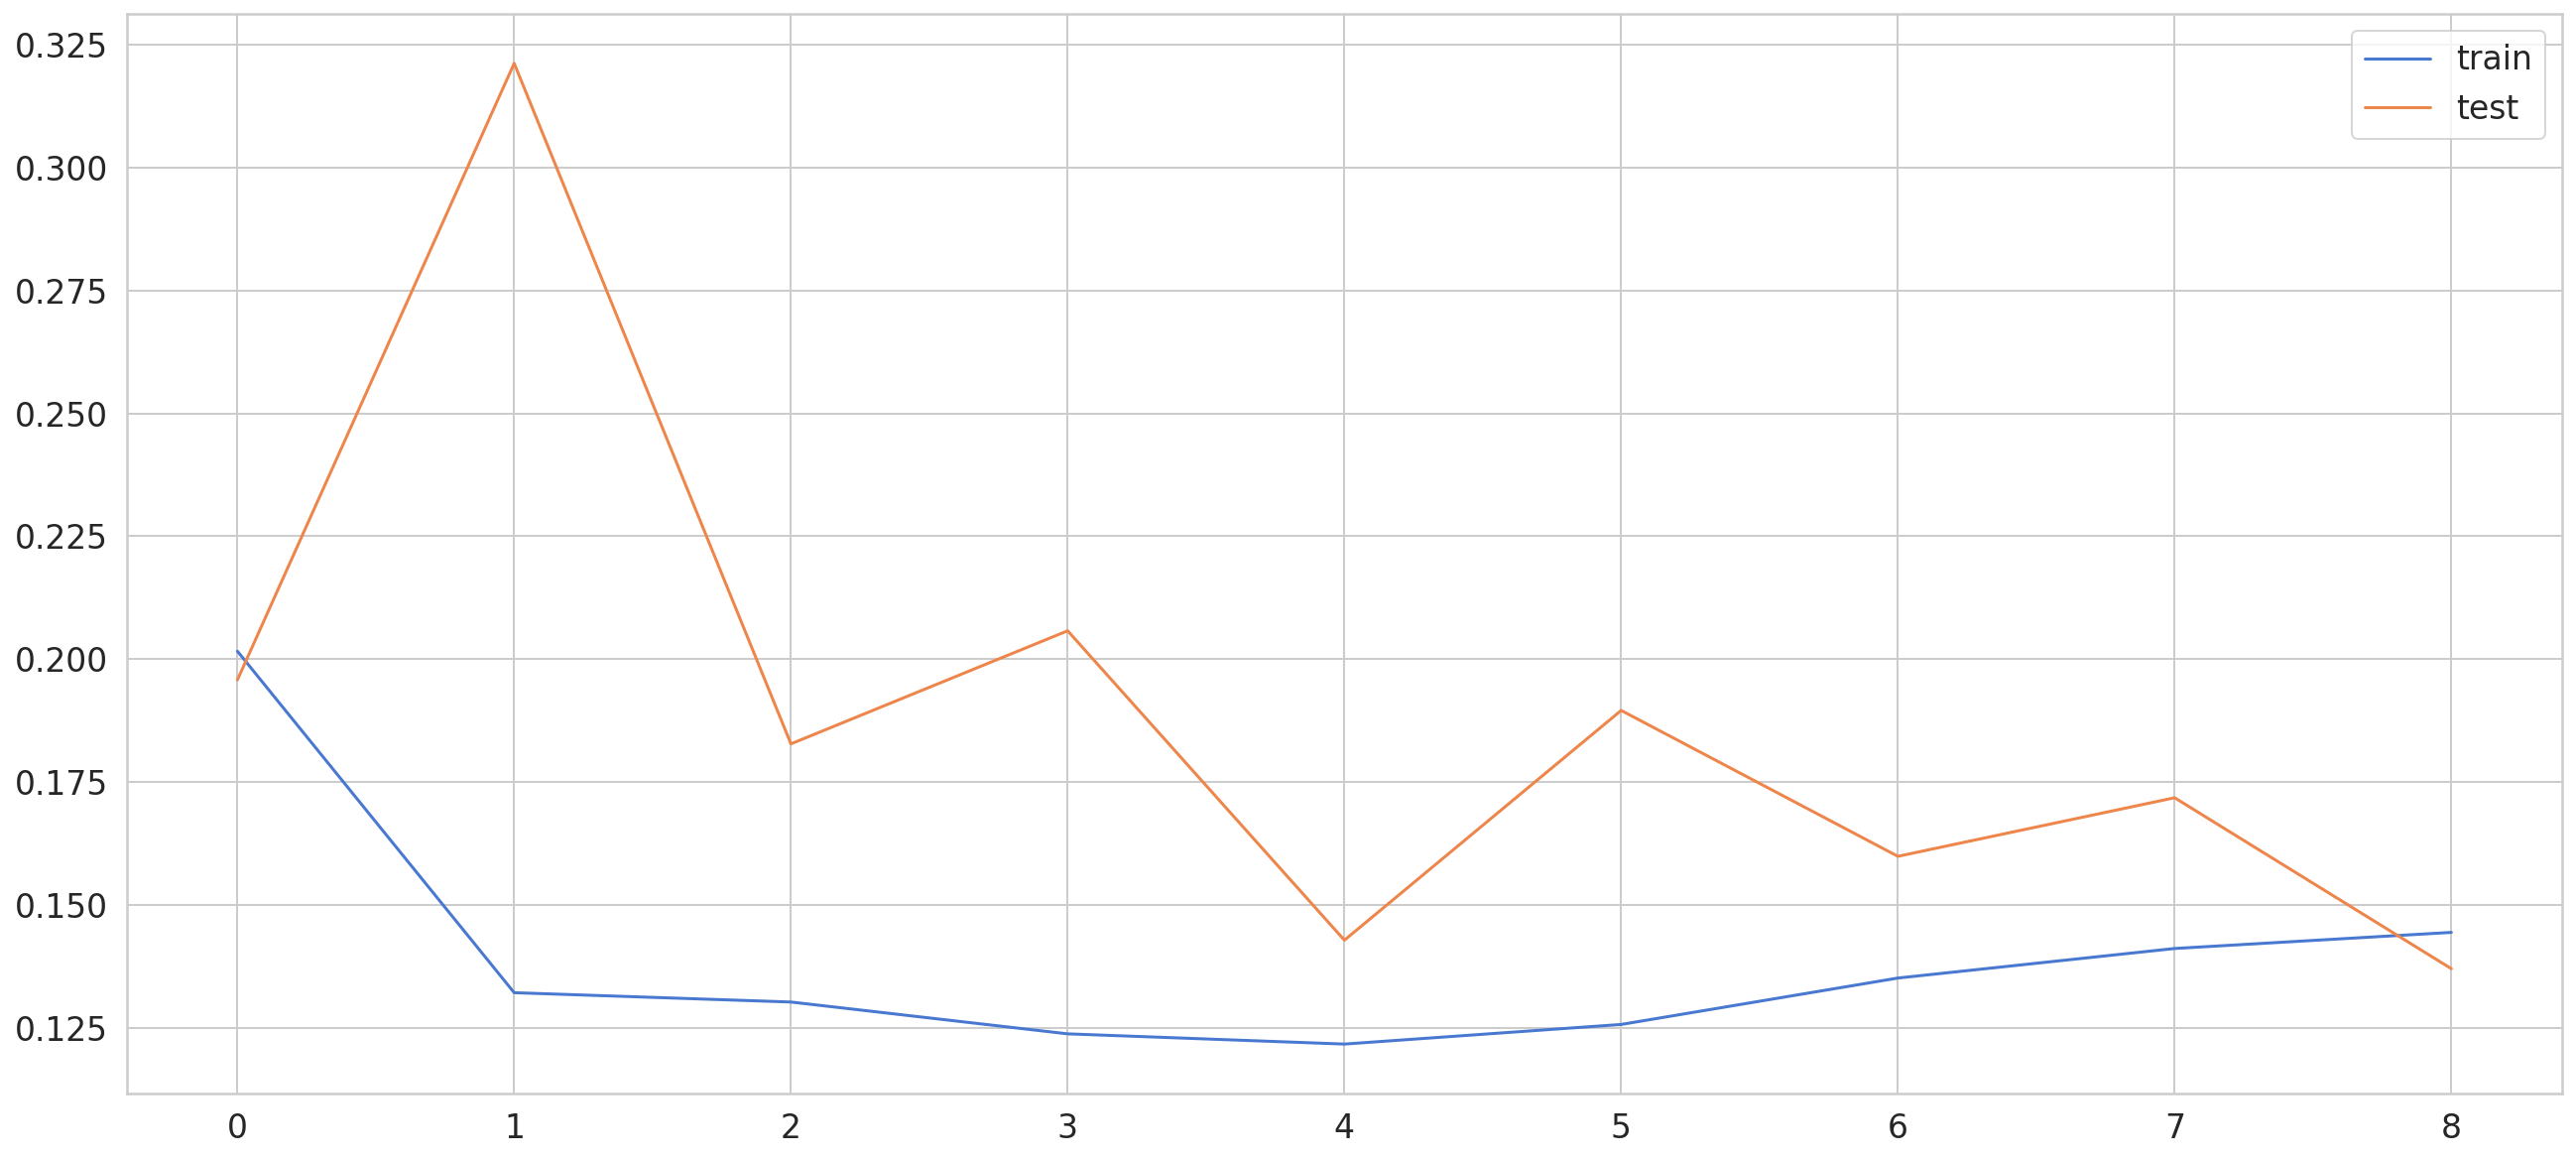

In [20]:
plt.plot(hist3.history['loss'], label='train')
plt.plot(hist3.history['val_loss'], label='test')
plt.legend()
plt.show()

<a name='find_anomaly'></a>
## 5. Find Anomalies

<a name='model1'></a>
### 5.1. Model 1

Calculating Mean Absolute Error (MAE) on training data

In [21]:
X_train_pred = model1.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

Plotting MAE

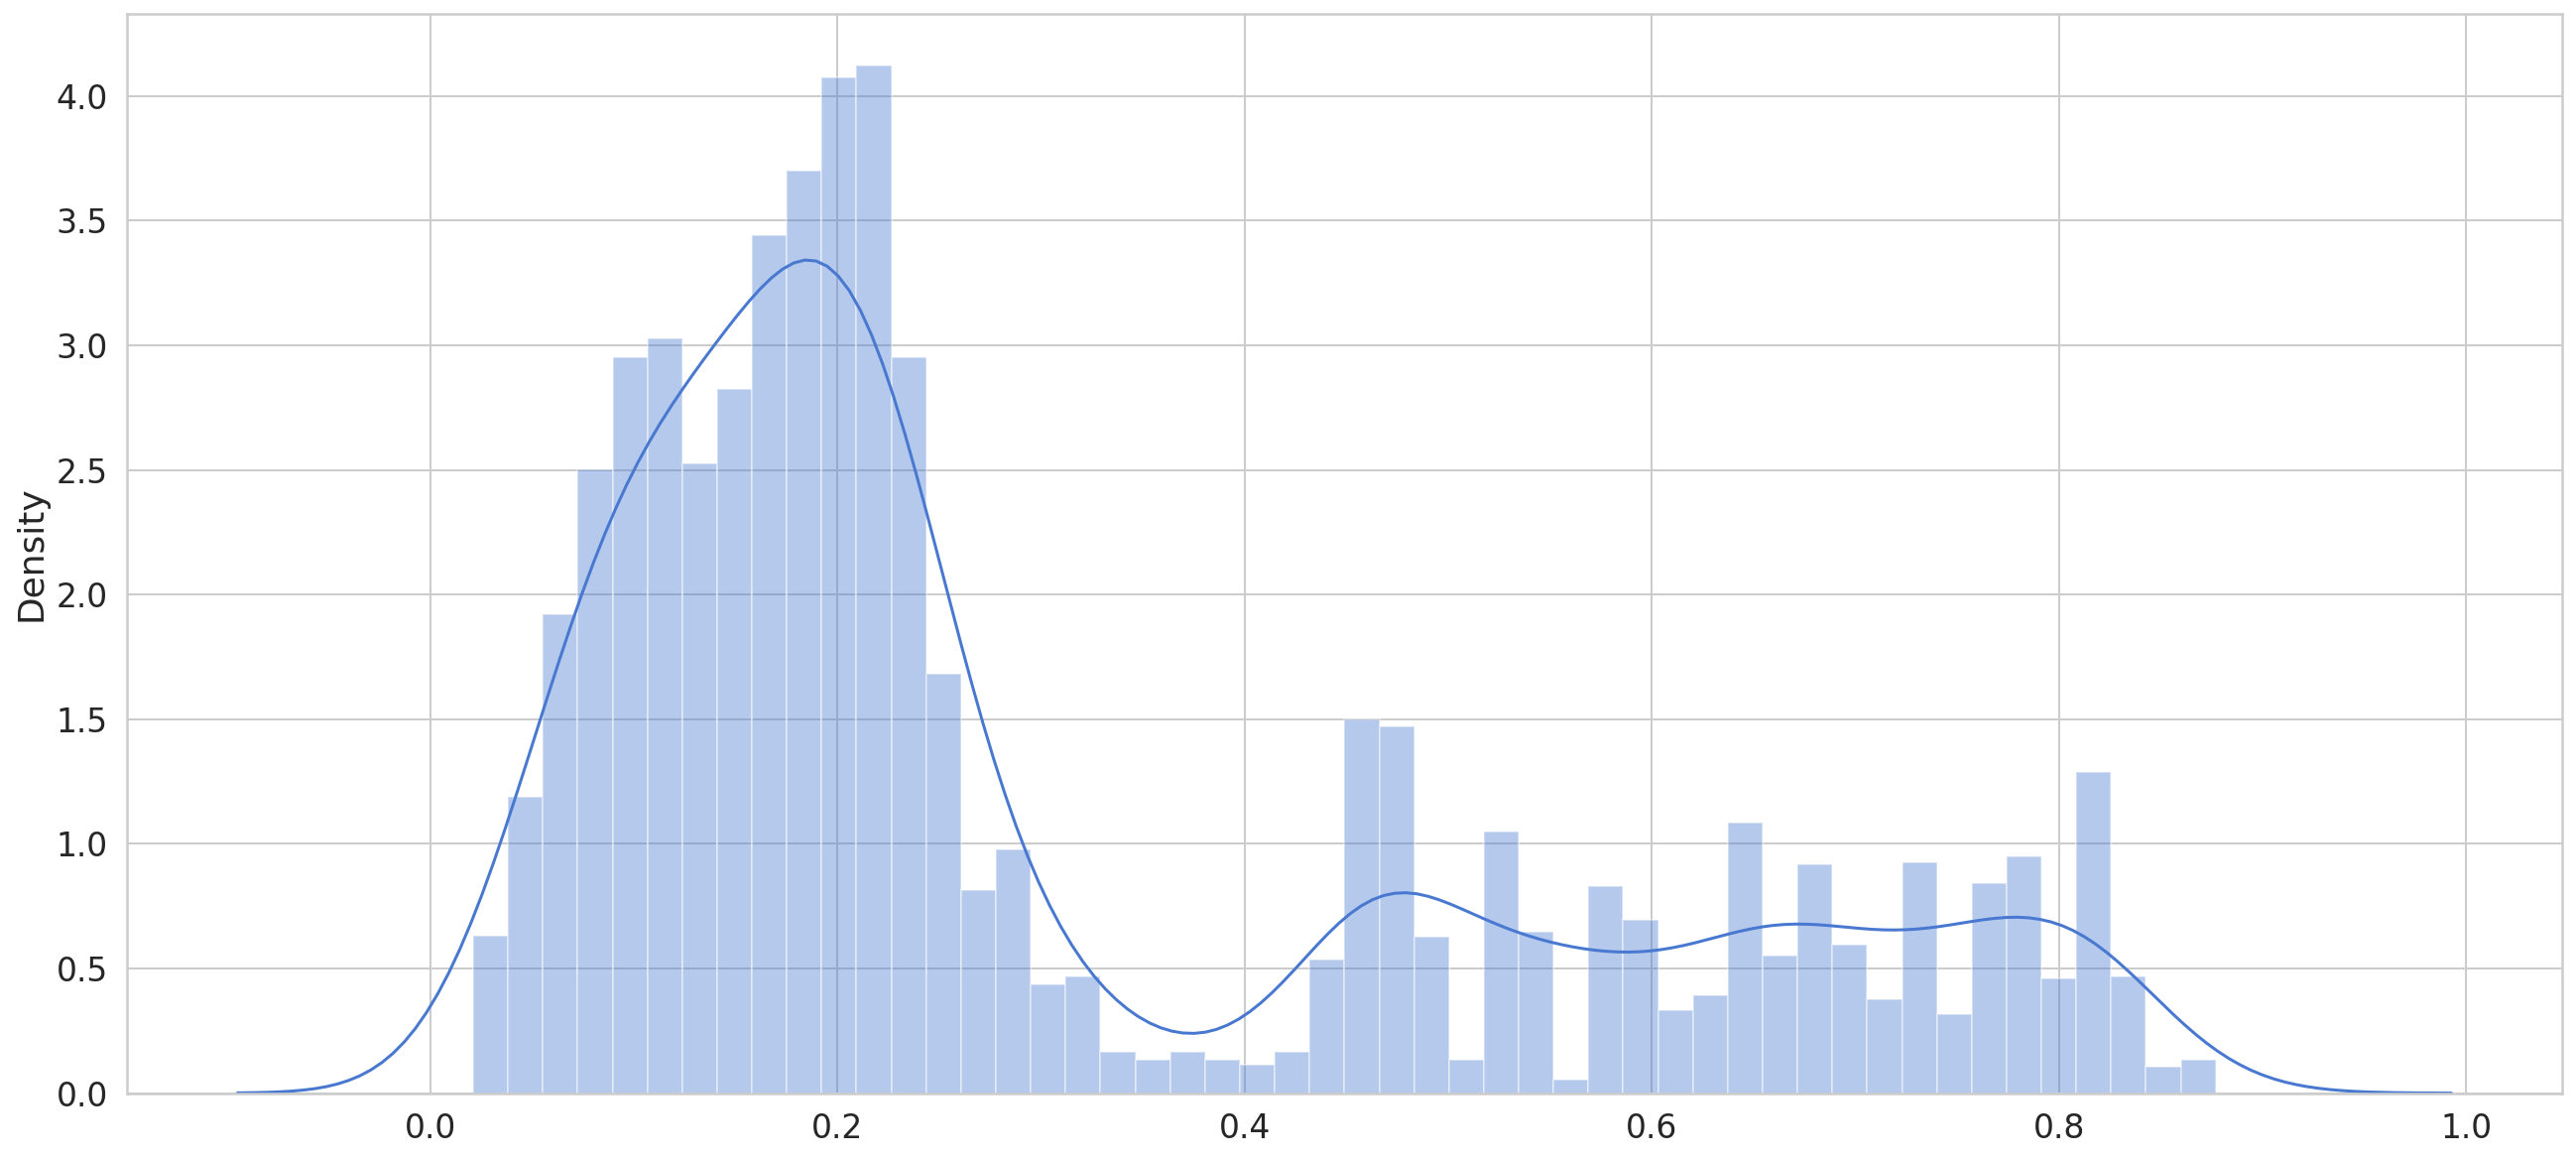

In [22]:
sns.distplot(train_mae_loss, bins=50, kde=True)
plt.show()

We’ll pick a threshold of 0.78, as not much of the loss is larger than that.

In [23]:
THRESHOLD = 0.78
X_test_pred = model1.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

Calculating the MAE on the test data

In [24]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)

test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

Plotting MAE

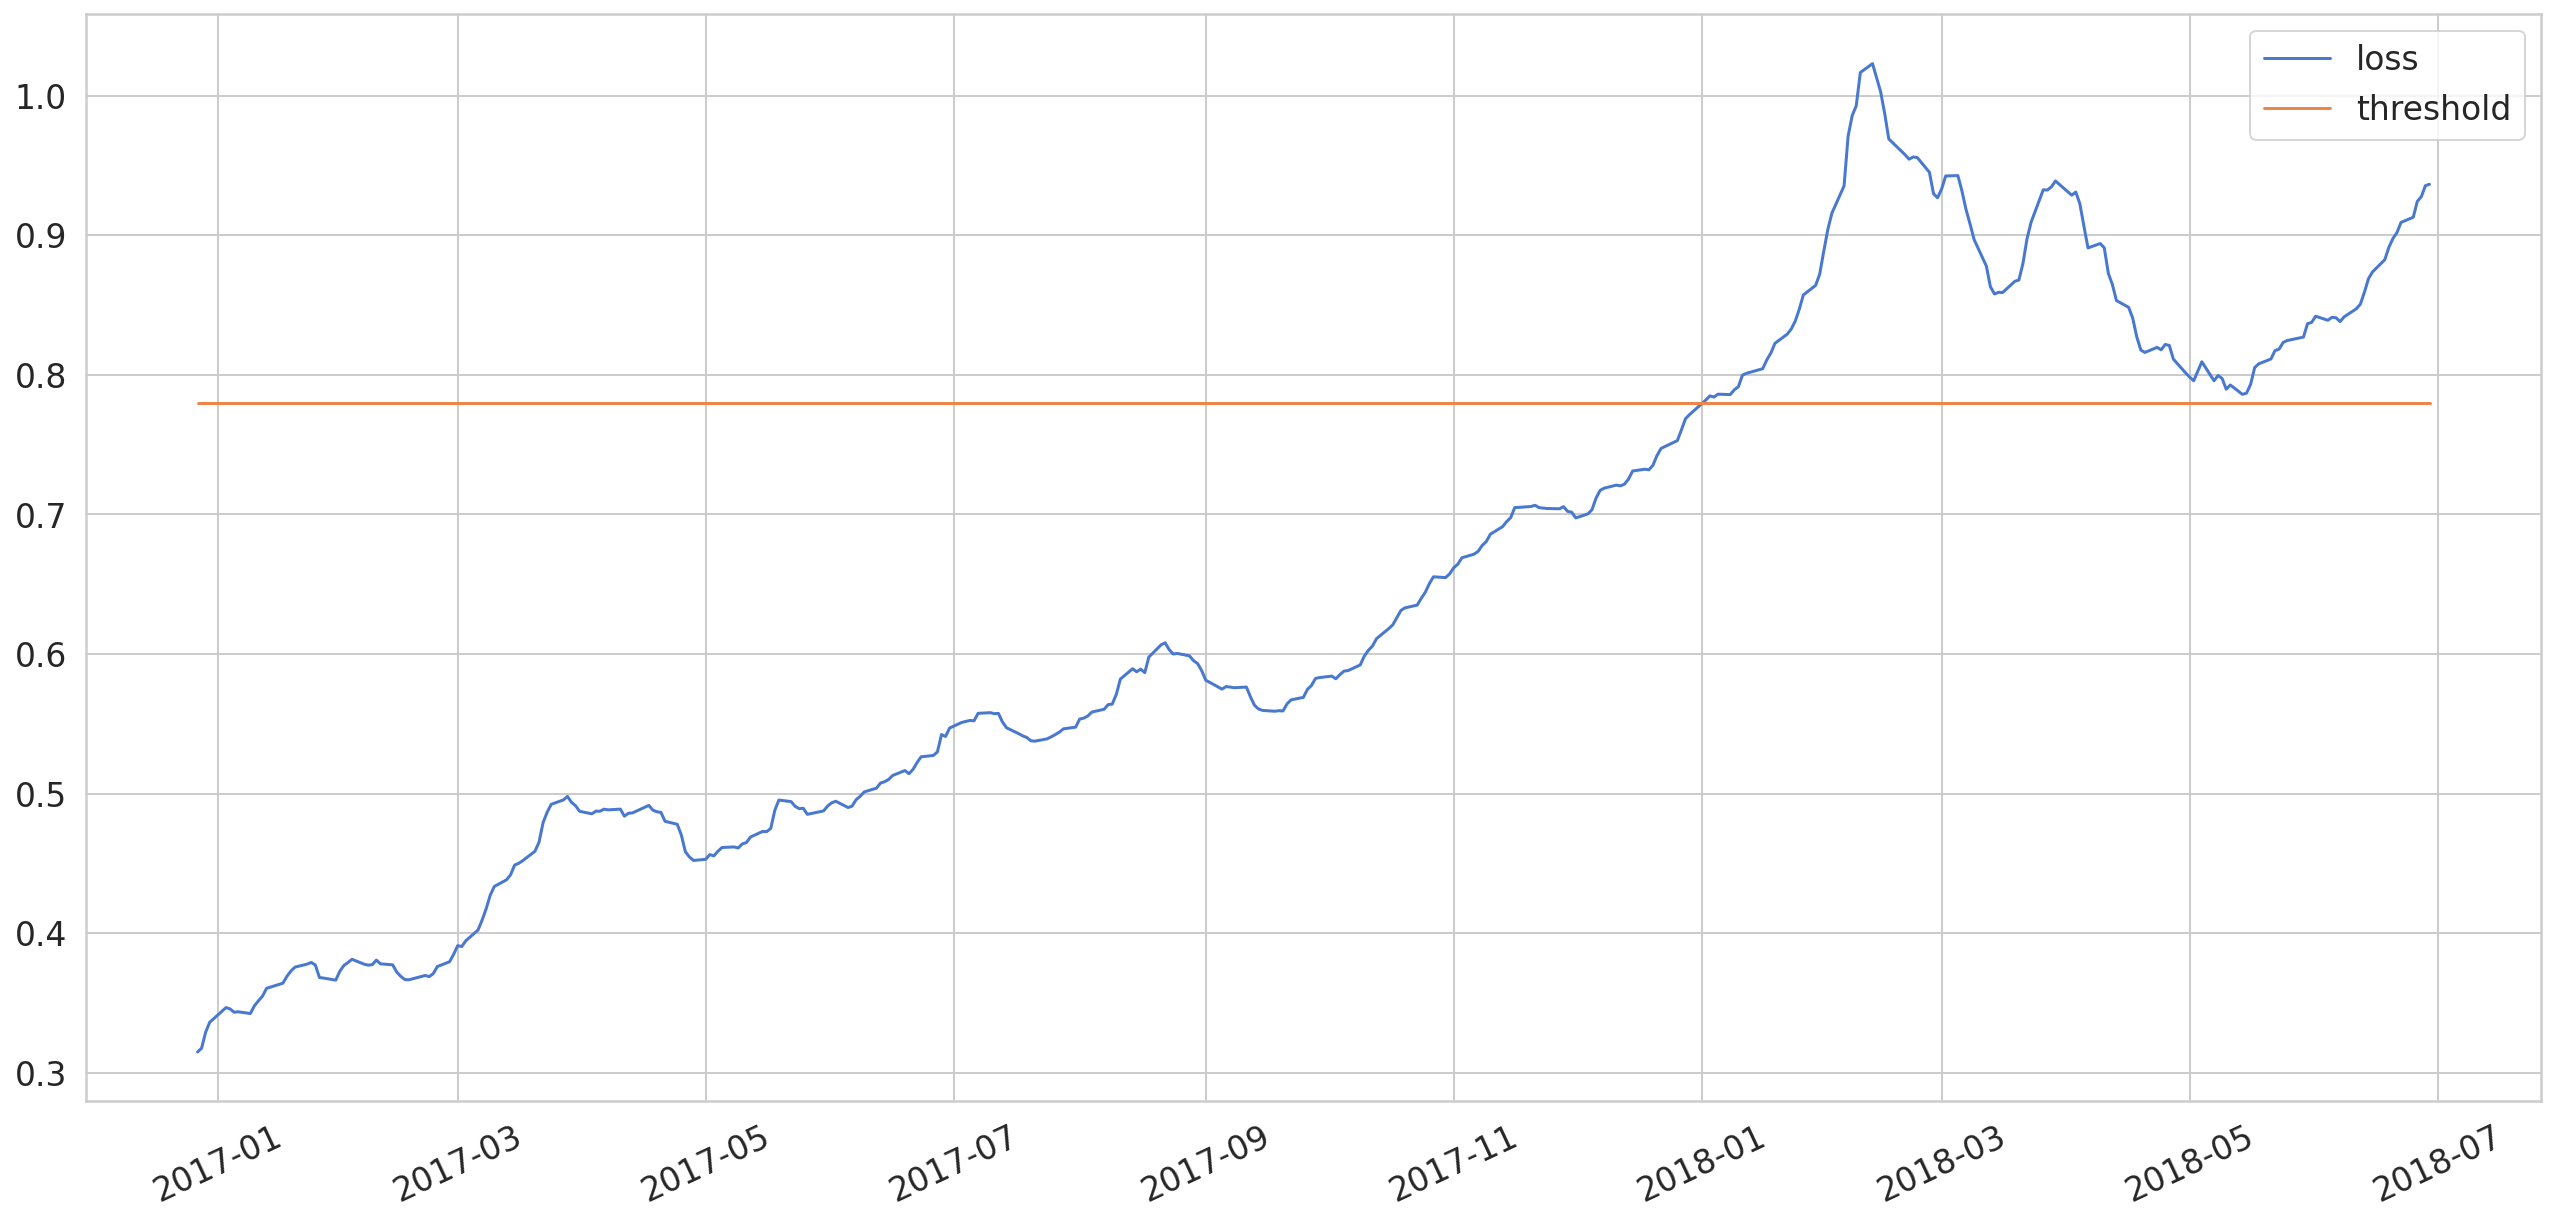

In [25]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()
plt.show()

In [26]:
anomalies1 = test_score_df[test_score_df.anomaly == True]
anomalies1.head()

,loss,threshold,anomaly,close
date,,,,
2018-01-02,0.781906,0.78,True,3.194714
2018-01-03,0.784892,0.78,True,3.227115
2018-01-04,0.784077,0.78,True,3.247644
2018-01-05,0.786109,0.78,True,3.283632
2018-01-08,0.785823,0.78,True,3.292197


<a name='model2'></a>
### 5.2. Model 2

In [27]:
X_train_pred = model2.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

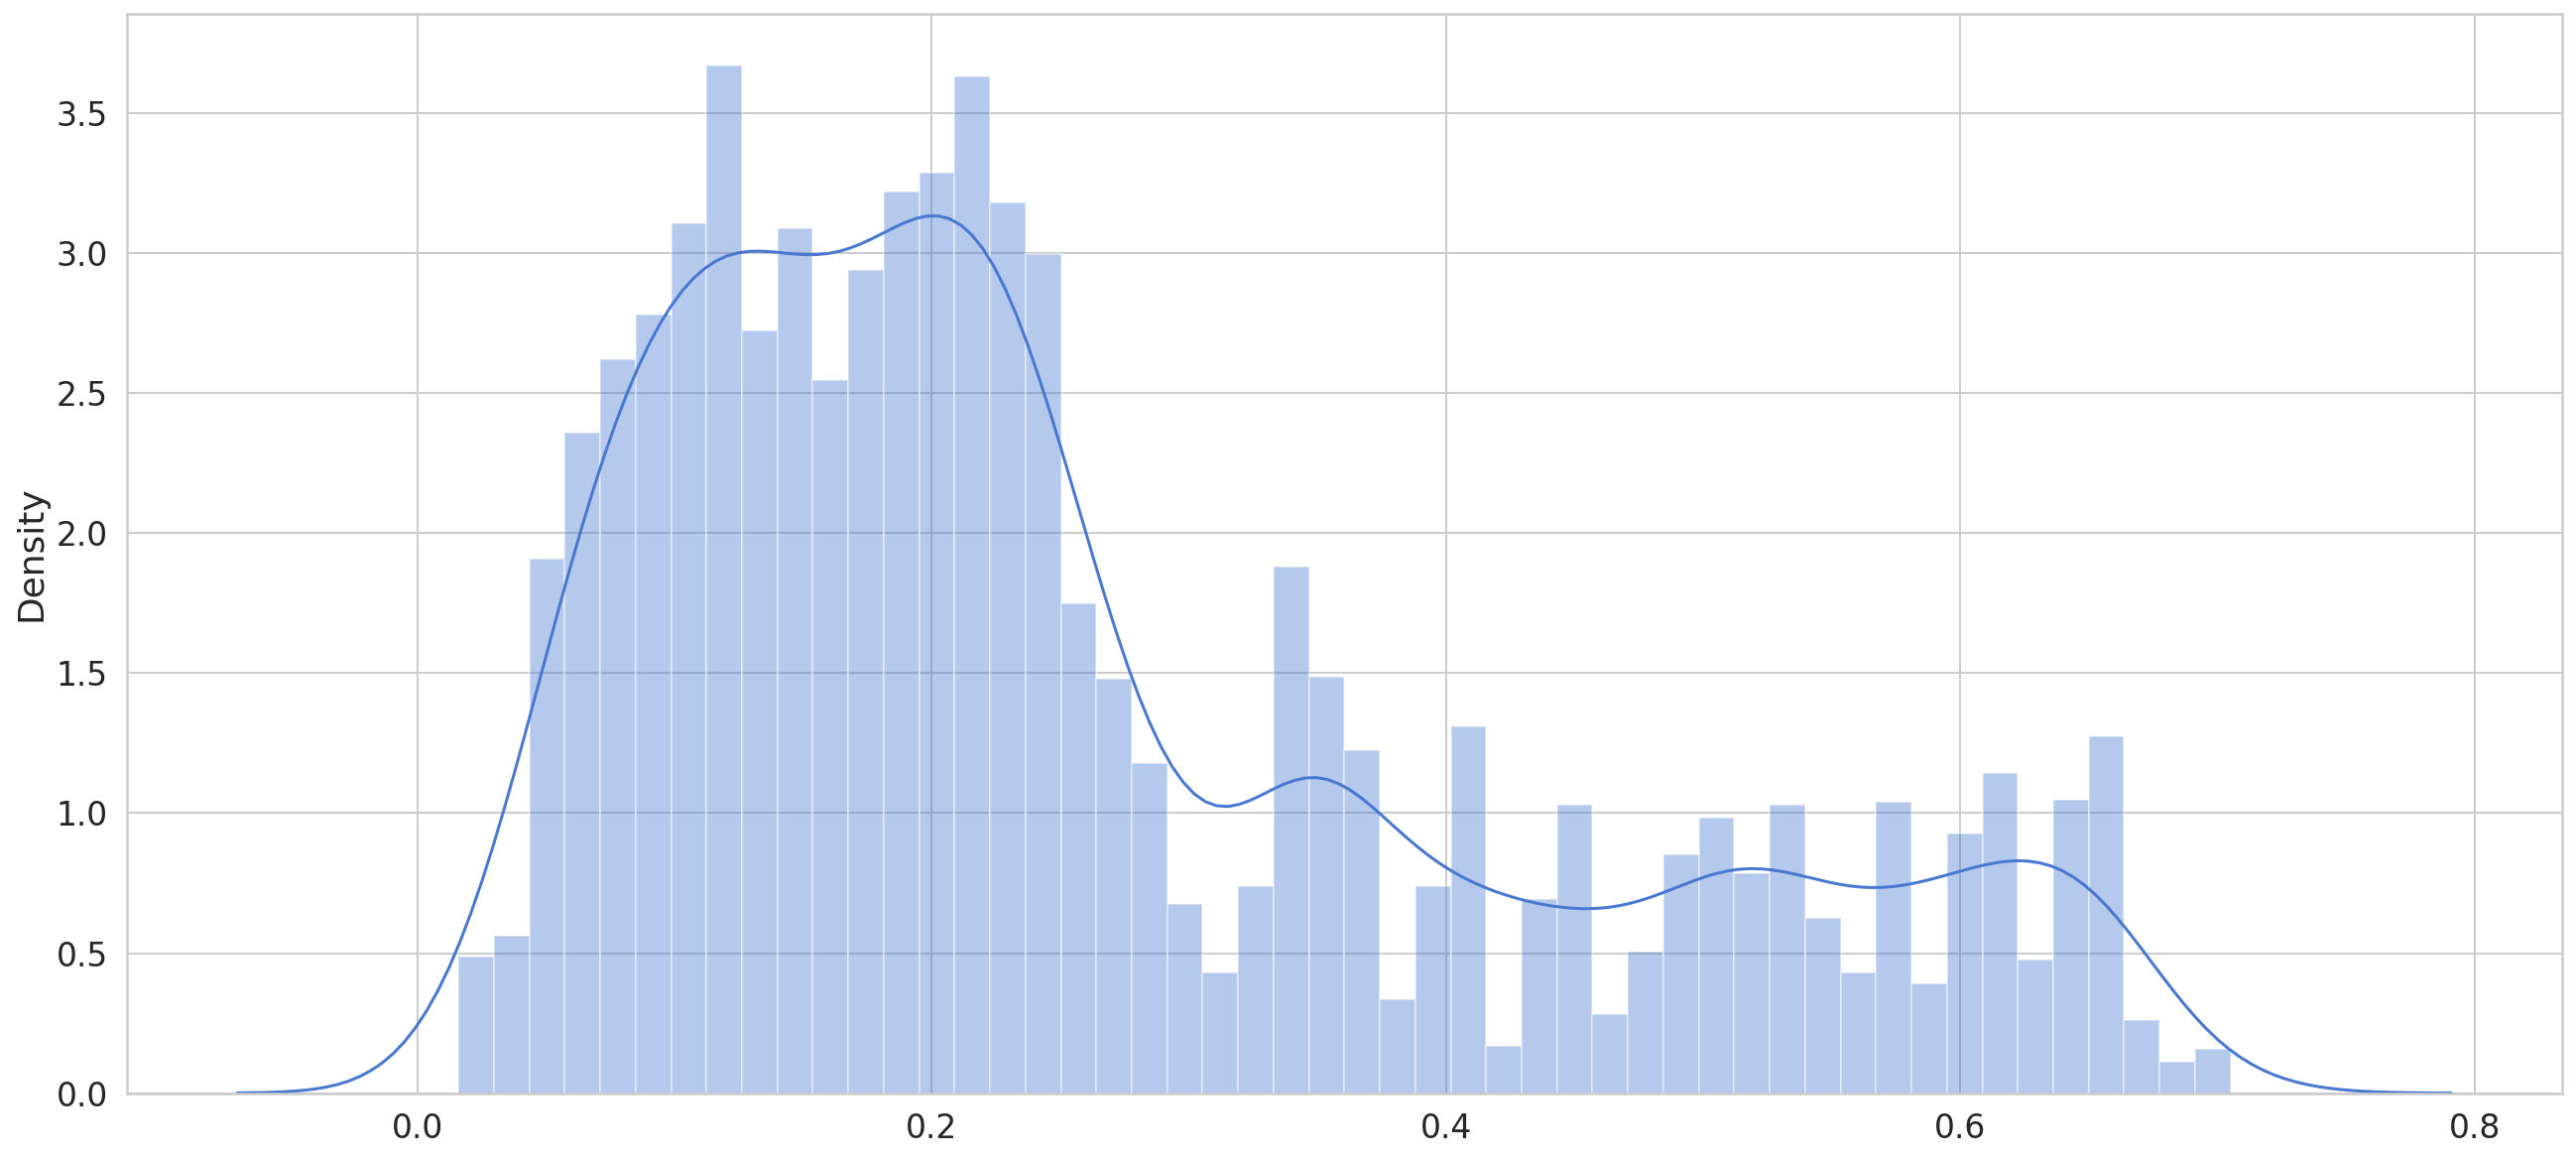

In [28]:
sns.distplot(train_mae_loss, bins=50, kde=True)
plt.show()

In [29]:
THRESHOLD = 0.88
X_test_pred = model2.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [30]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)

test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

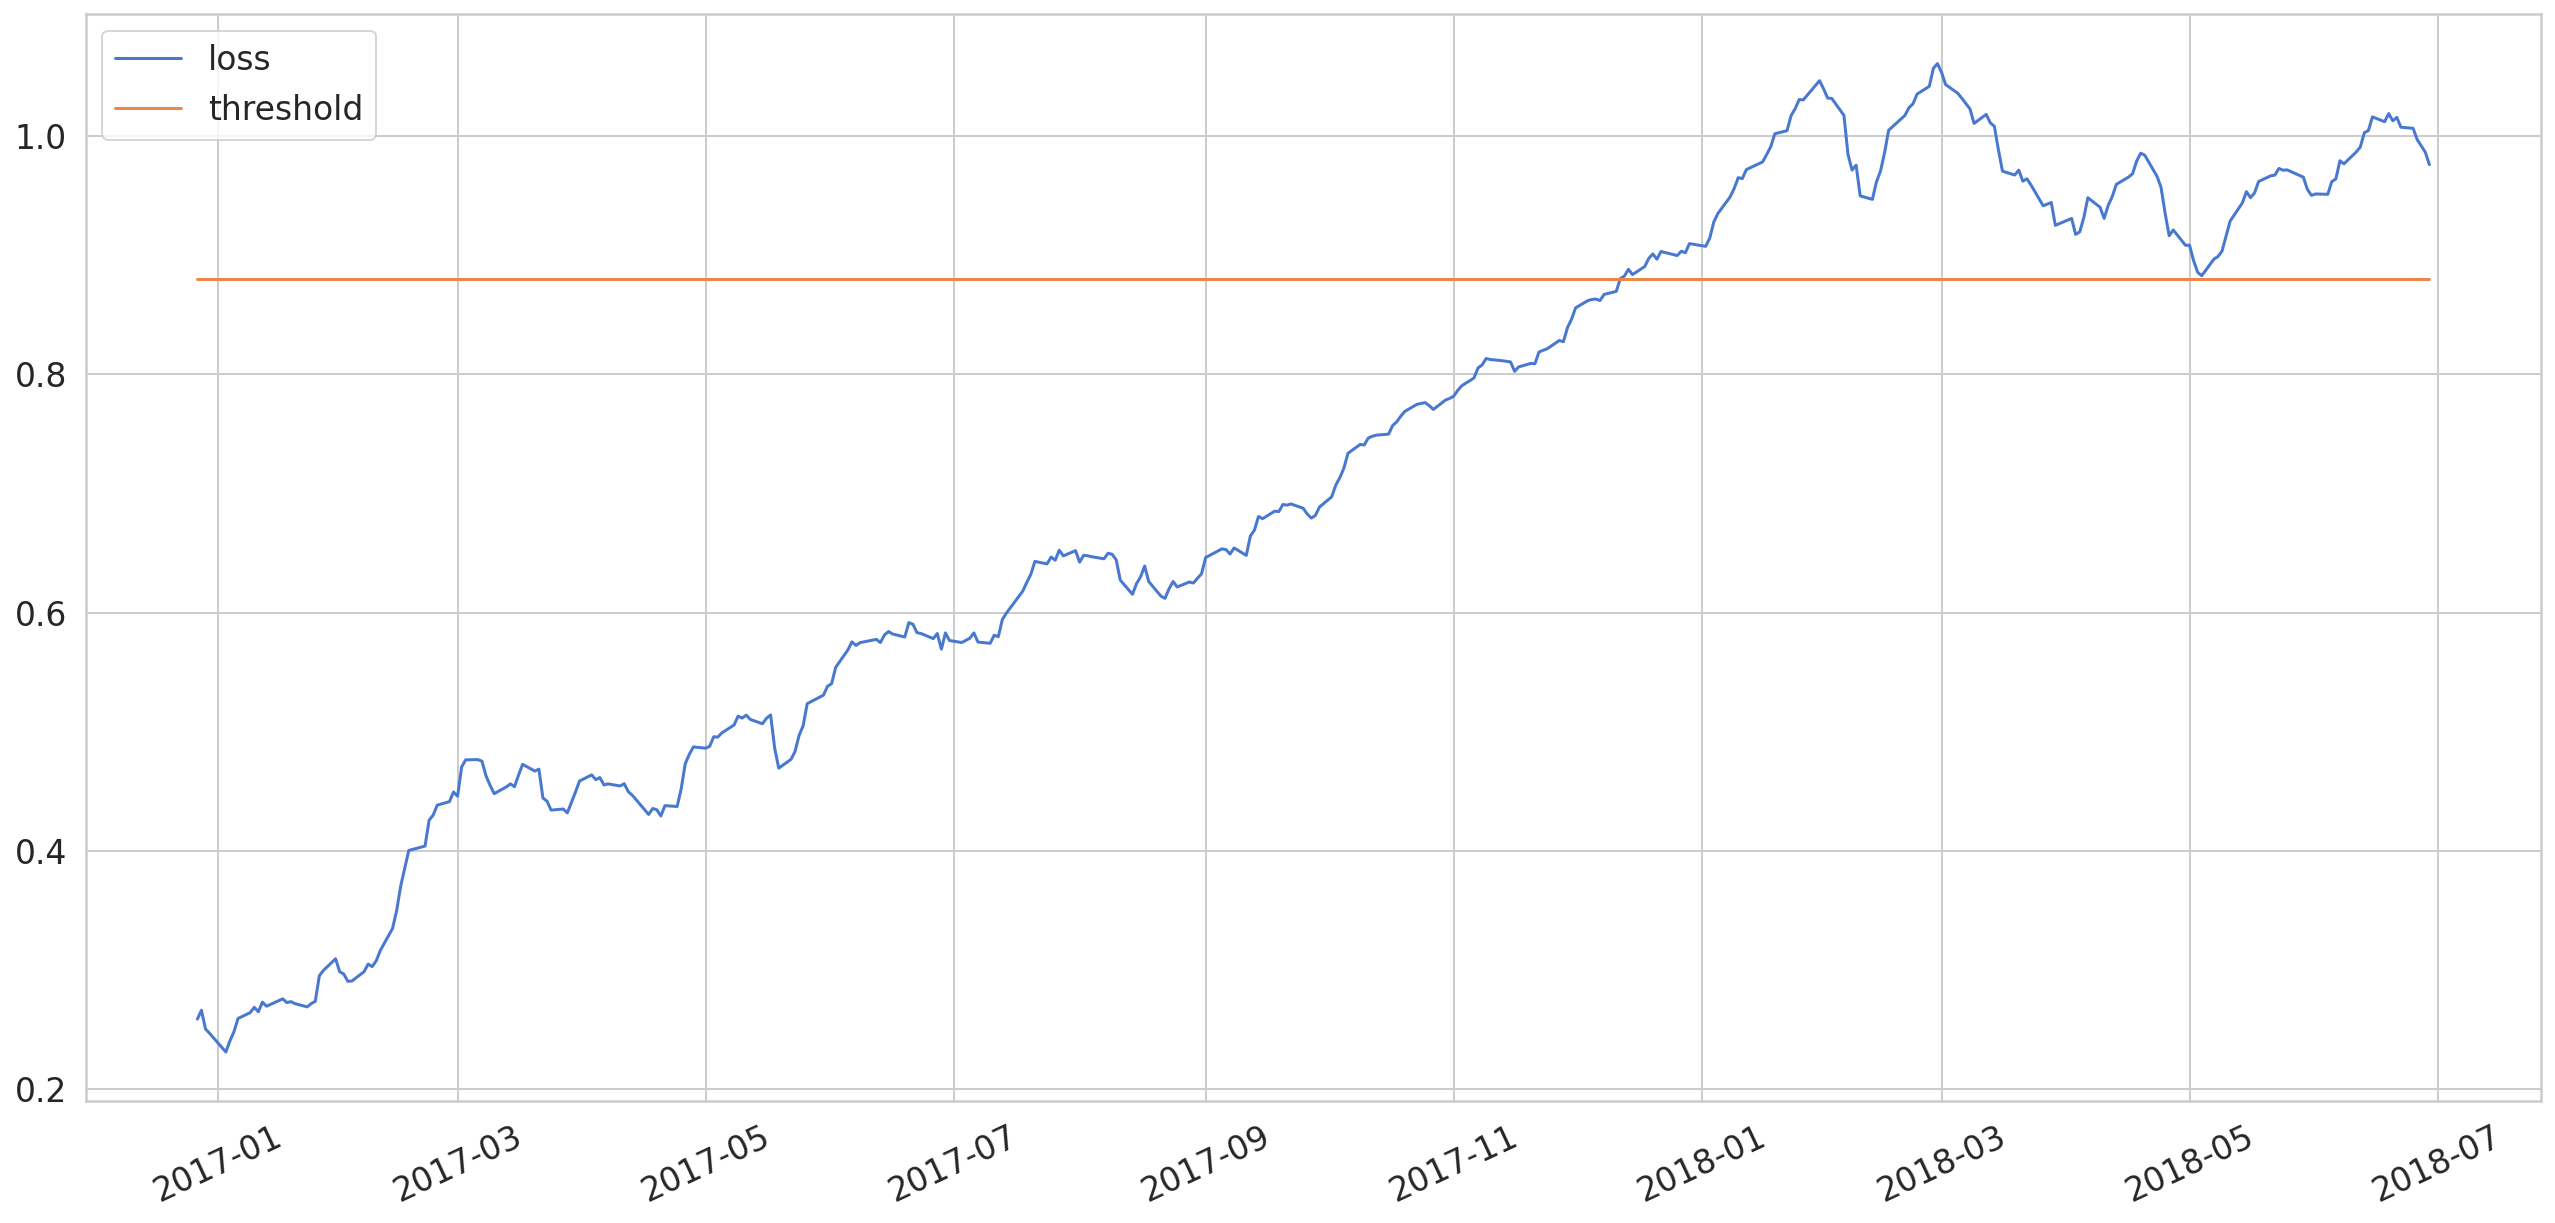

In [31]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()
plt.show()

In [32]:
anomalies2 = test_score_df[test_score_df.anomaly == True]
anomalies2.head()

,loss,threshold,anomaly,close
date,,,,
2017-12-12,0.880271,0.88,True,3.135172
2017-12-13,0.882399,0.88,True,3.132806
2017-12-14,0.888039,0.88,True,3.112445
2017-12-15,0.883662,0.88,True,3.157148
2017-12-18,0.890378,0.88,True,3.184102


<a name='model3'></a>
### 5.3. Model 3

In [33]:
X_train_pred = model3.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

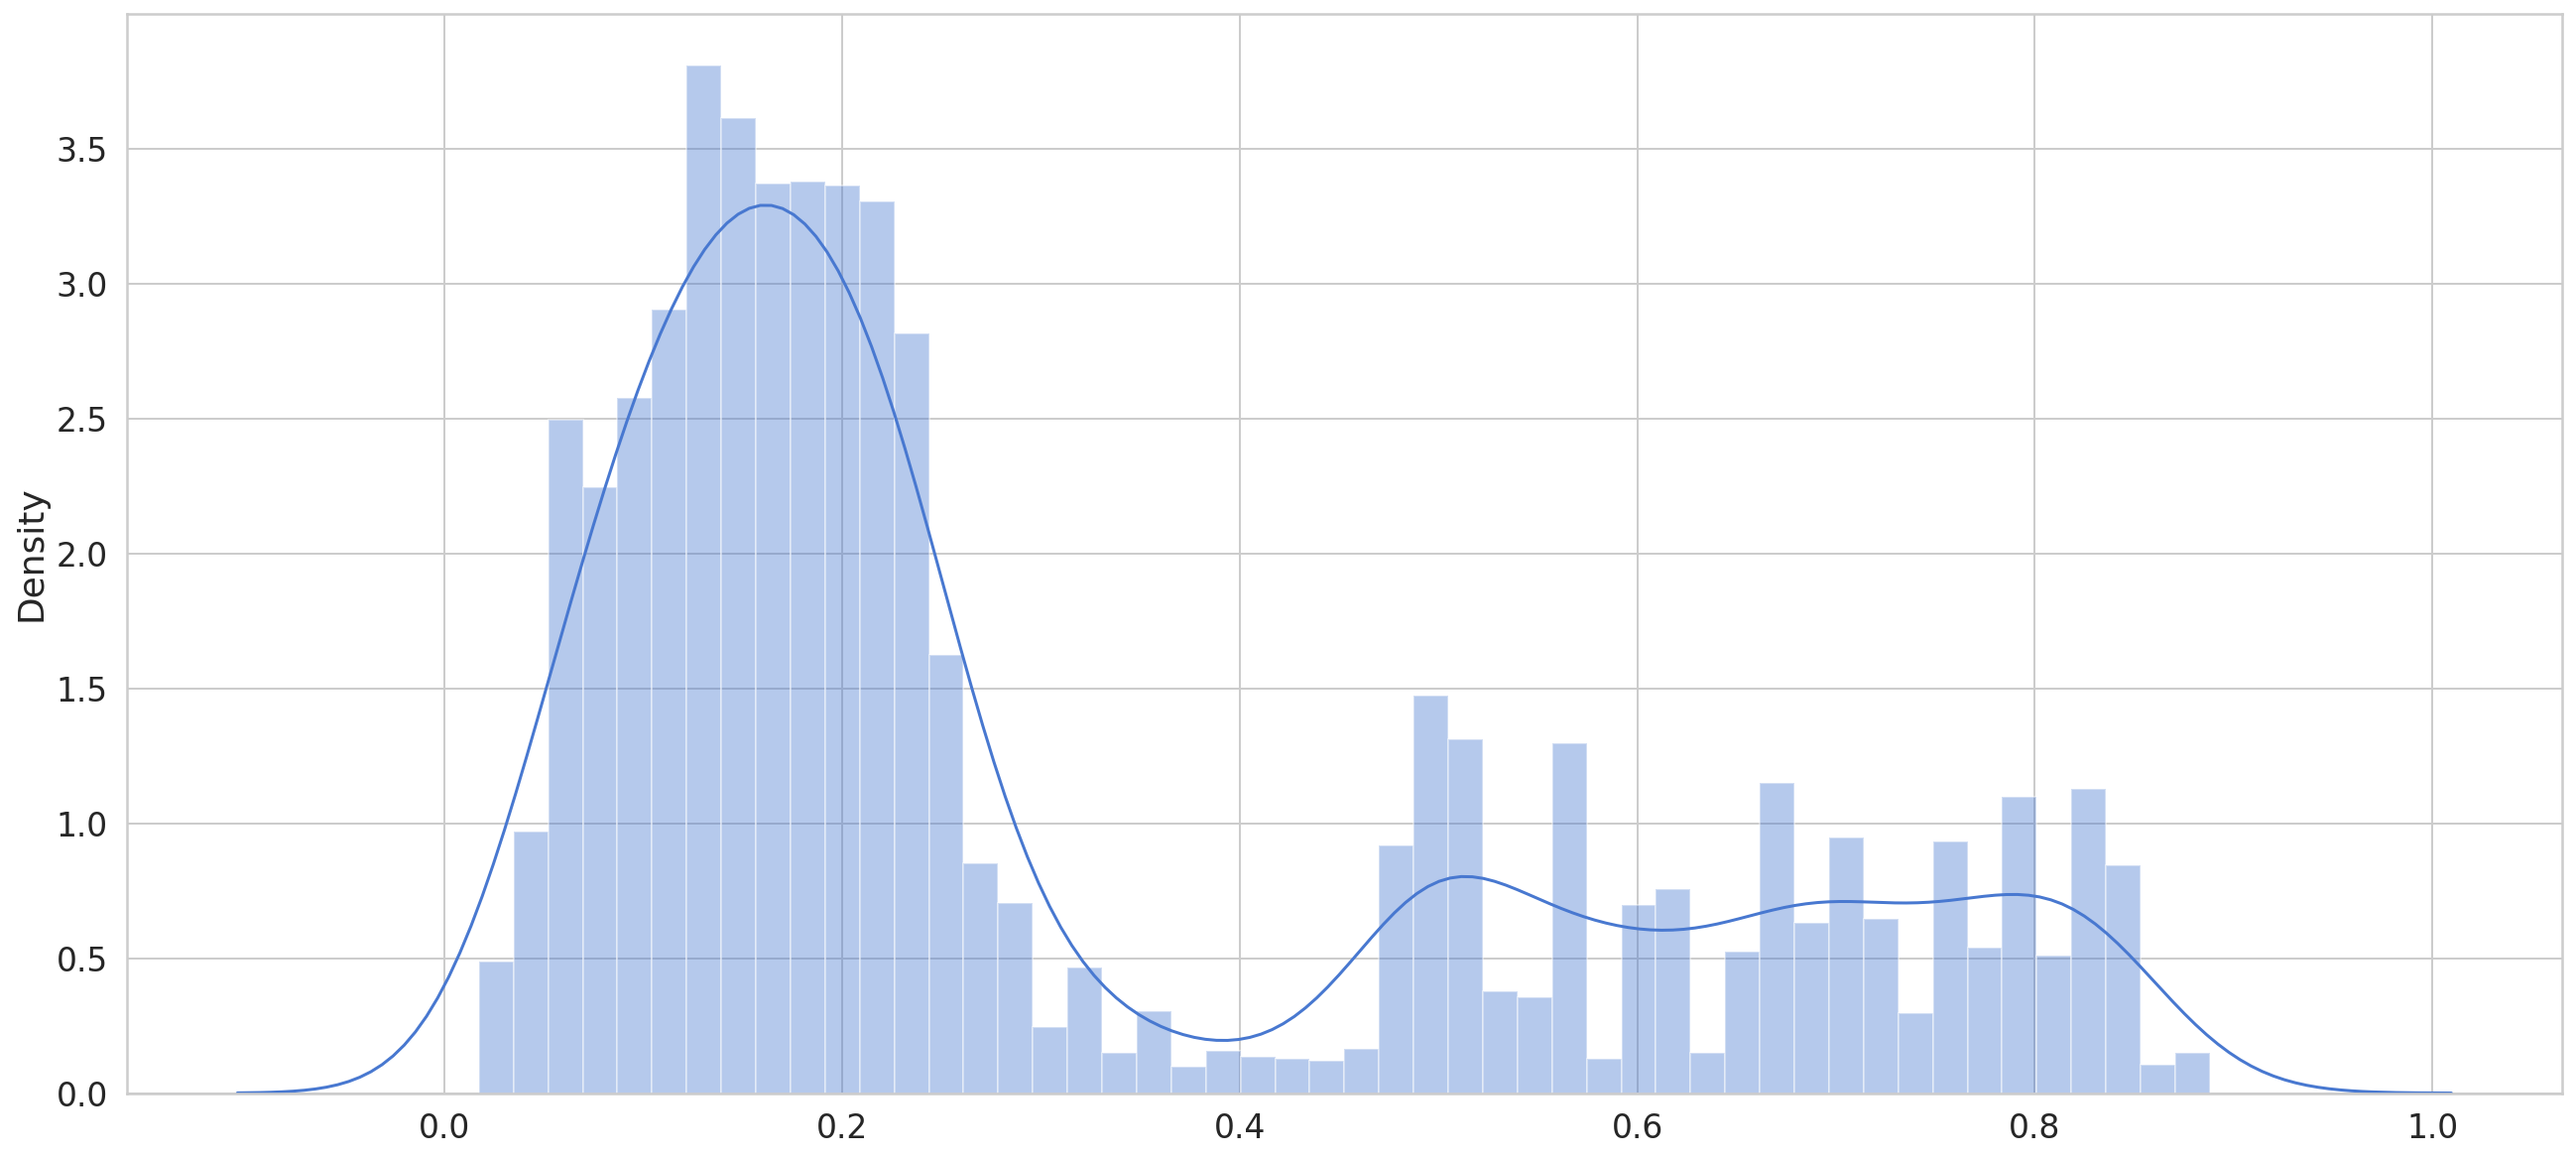

In [34]:
sns.distplot(train_mae_loss, bins=50, kde=True)
plt.show()

In [35]:
THRESHOLD = 0.45
X_test_pred = model3.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [36]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)

test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

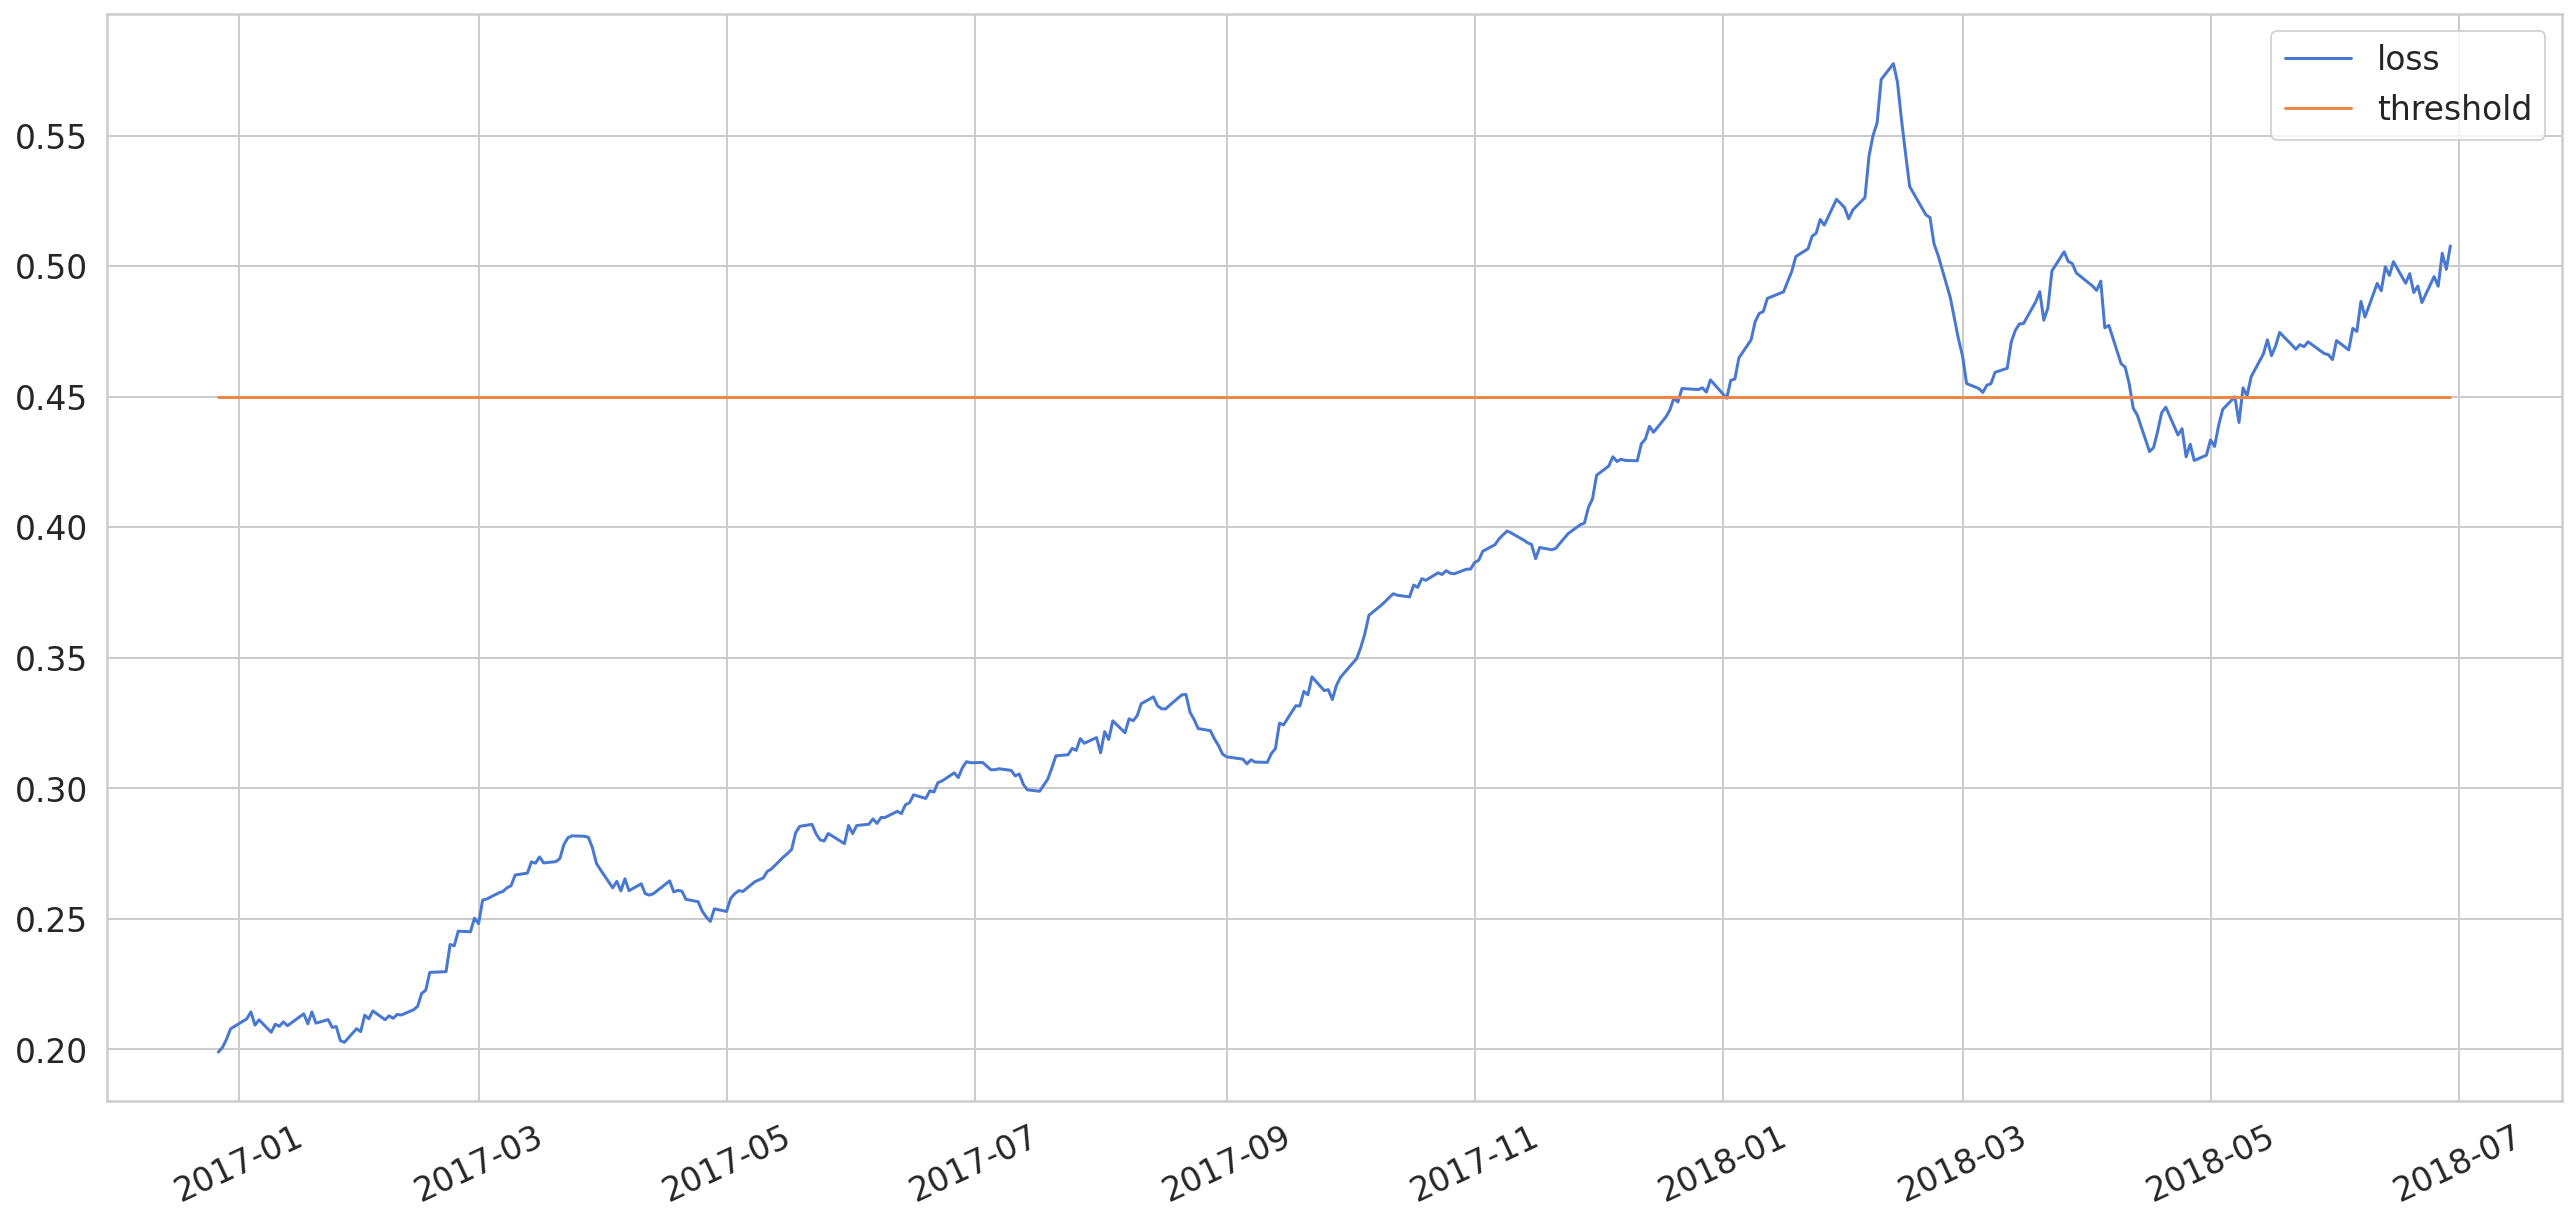

In [37]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()
plt.show()

In [38]:
anomalies3 = test_score_df[test_score_df.anomaly == True]
anomalies3.head()

,loss,threshold,anomaly,close
date,,,,
2017-12-22,0.453138,0.45,True,3.171292
2017-12-26,0.452724,0.45,True,3.165957
2017-12-27,0.453411,0.45,True,3.169939
2017-12-28,0.451755,0.45,True,3.179181
2017-12-29,0.456437,0.45,True,3.153016
